# ÜSKÜDAR ÜNİVERSİTESİ
# Yapay Sinir Ağları Dersi
# Ara Sınav Ödevi – MLP Sınıflandırma Projesi + XAI (SHAP) Analizi

Bu ara sınav ödevinde, scikit-learn'den yüklenen "Wine Classification" veri seti üzerinde yapay sinir ağı tabanlı bir sınıflandırıcı geliştirdim, veri ön işleme teknikleri uyguladım, hiperparametre optimizasyonu gerçekleştirdim ve XAI (Açıklanabilir Yapay Zeka) yöntemleri kullanarak modelleri yorumladım.

**Aşağıdaki tüm adımları kapsamlı bir şekilde tamamladım ve her bölümün sonuna kısa yorumlar ekledim.**


# 1. Veri Setinin Yüklenmesi
1.1 scikit-learn’den Veri Seti Yükleme
Kullanılabilecek veri setleri:
Breast Cancer Wisconsin
Wine Classification

1.2 Veri Çerçevesi Oluşturma
X (özellikler) ve y (hedef) değişkenlerini ayırın.
pandas DataFrame formatına dönüştürünüz.
İlk 5 satırı görüntüleyiniz.


In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.datasets import load_wine
from itertools import cycle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load Dataset
data = load_wine()

# Convert to DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

X = df.drop('target', axis=1)
y = df['target']

print("Class Distribution:", y.value_counts())
print("Display the first 5 rows:\n", df.head())

Class Distribution: target
1    71
0    59
2    48
Name: count, dtype: int64
Display the first 5 rows:
    alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39   

# 2. Veri Seti Kalite Kontrolleri
2.1 Eksik Değer Analizi

Her sütunda missing value kontrolü yapınız.
Eksik değer varsa uygun yöntemle doldurunuz.

2.2 Aykırı Değer (Outlier) Analizi

Aşağıdakilerden en az birini uygulayınız:
IQR yöntemi
Z-score analizi
Boxplot incelemesi

2.3 Veri Tipi ve Dağılım İncelemesi

Sayısal / kategorik değişken sayılarını raporlayın.
Sütunların dtype bilgilerini gösterin.


In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

Scikit-learn'deki yerleşik Wine veri kümesinde eksik değer yoktur.

In [3]:
def detect_outliers_iqr(dataframe, column):
    """
    Define an outlier in the column
    """
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
    return outliers, lower_bound, upper_bound, Q1, Q3, IQR

print("Outlier analysis")

outliers_summary = {}

for column in df.columns:
    if df[column].dtype in ['float64', 'int64']:  # numerical columns only used
        outliers, lower_bound, upper_bound, Q1, Q3, IQR = detect_outliers_iqr(df, column)

        outliers_summary[column] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(df)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

        print(f"\n📊 Column: {column}")
        print(f"   Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
        print(f"   Bound: [{lower_bound:.2f}, {upper_bound:.2f}]")
        print(f"   Outliers: {len(outliers)} ({outliers_summary[column]['percentage']:.1f}%)")



Outlier analysis

📊 Column: alcohol
   Q1: 12.36, Q3: 13.68, IQR: 1.32
   Bound: [10.39, 15.65]
   Outliers: 0 (0.0%)

📊 Column: malic_acid
   Q1: 1.60, Q3: 3.08, IQR: 1.48
   Bound: [-0.62, 5.30]
   Outliers: 3 (1.7%)

📊 Column: ash
   Q1: 2.21, Q3: 2.56, IQR: 0.35
   Bound: [1.69, 3.08]
   Outliers: 3 (1.7%)

📊 Column: alcalinity_of_ash
   Q1: 17.20, Q3: 21.50, IQR: 4.30
   Bound: [10.75, 27.95]
   Outliers: 4 (2.2%)

📊 Column: magnesium
   Q1: 88.00, Q3: 107.00, IQR: 19.00
   Bound: [59.50, 135.50]
   Outliers: 4 (2.2%)

📊 Column: total_phenols
   Q1: 1.74, Q3: 2.80, IQR: 1.06
   Bound: [0.16, 4.39]
   Outliers: 0 (0.0%)

📊 Column: flavanoids
   Q1: 1.21, Q3: 2.88, IQR: 1.67
   Bound: [-1.30, 5.38]
   Outliers: 0 (0.0%)

📊 Column: nonflavanoid_phenols
   Q1: 0.27, Q3: 0.44, IQR: 0.17
   Bound: [0.02, 0.69]
   Outliers: 0 (0.0%)

📊 Column: proanthocyanins
   Q1: 1.25, Q3: 1.95, IQR: 0.70
   Bound: [0.20, 3.00]
   Outliers: 2 (1.1%)

📊 Column: color_intensity
   Q1: 3.22, Q3: 6.20, IQ

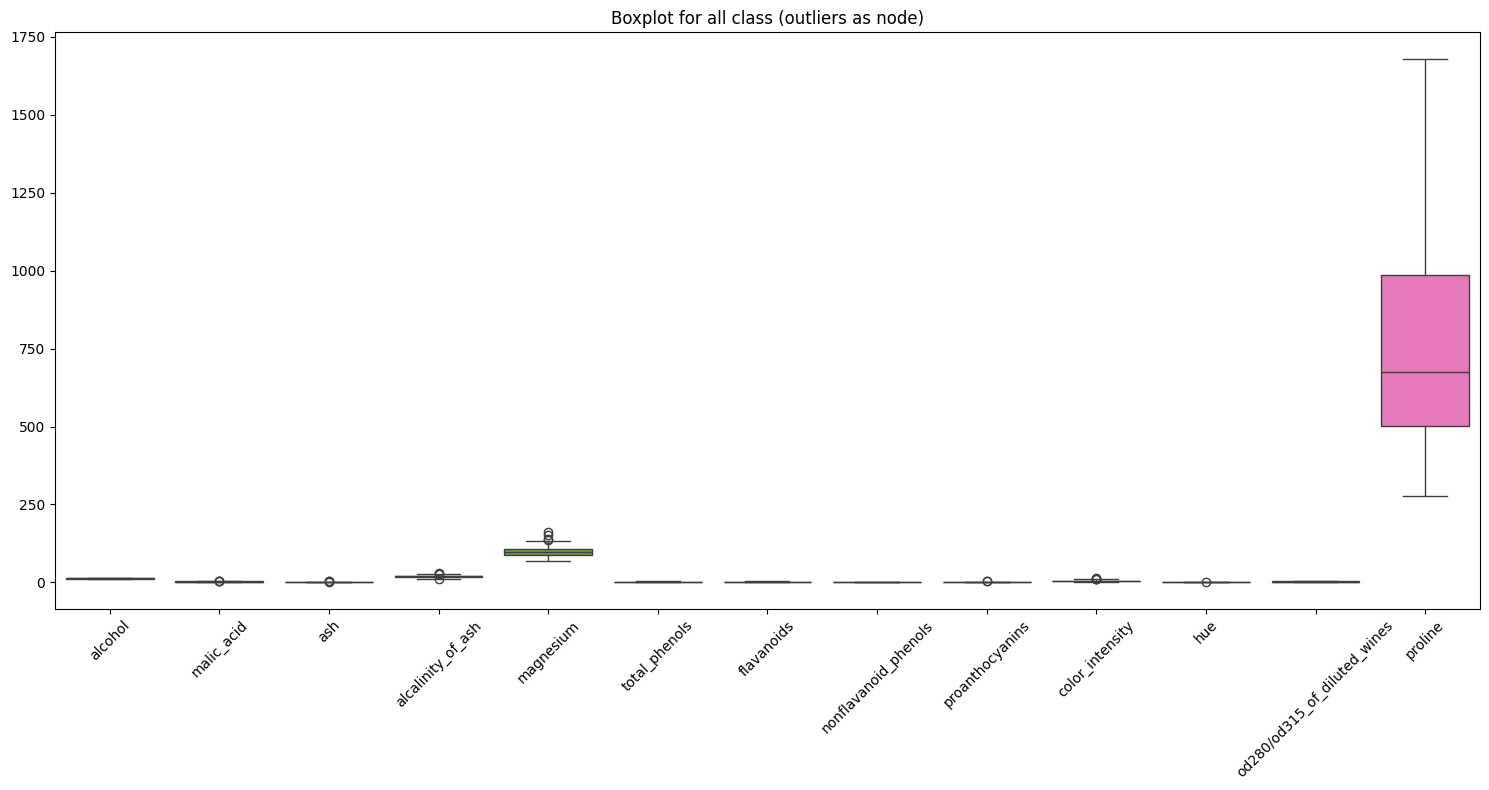

In [4]:
plt.figure(figsize=(15, 8))
df_numeric = df.drop('target', axis=1)
sns.boxplot(data=df_numeric)
plt.xticks(rotation=45)
plt.title('Boxplot for all class (outliers as node)')
plt.tight_layout()
plt.show()

In [5]:
def quick_summary(dataframe):
    """
    Data tyoe summary
    """
    numeric_cols = dataframe.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = dataframe.select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"Total columns: {len(dataframe.columns)}")
    print(f"📈 Numerical columns: {len(numeric_cols)}")
    print(f"📝 Categorical columns: {len(categorical_cols)}")

    print(f"\nNumerical columns ({len(numeric_cols)}):")
    for col in numeric_cols:
        print(f"  • {col} ({dataframe[col].dtype})")

    print(f"\nCategorical columns ({len(categorical_cols)}):")
    for col in categorical_cols:
        print(f"  • {col} ({dataframe[col].dtype})")

    print(f"\nData type information of columns:")
    print(dataframe.dtypes.to_string())

quick_summary(df)

Total columns: 14
📈 Numerical columns: 14
📝 Categorical columns: 0

Numerical columns (14):
  • alcohol (float64)
  • malic_acid (float64)
  • ash (float64)
  • alcalinity_of_ash (float64)
  • magnesium (float64)
  • total_phenols (float64)
  • flavanoids (float64)
  • nonflavanoid_phenols (float64)
  • proanthocyanins (float64)
  • color_intensity (float64)
  • hue (float64)
  • od280/od315_of_diluted_wines (float64)
  • proline (float64)
  • target (int64)

Categorical columns (0):

Data type information of columns:
alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    floa

# 3. Keşifsel Veri Analizi (EDA)
3.1 İstatistiksel Özellikler

Her sütun için aşağıdaki değerleri hesaplayın:
Mean
Median
Min–Max
Std
Q1–Q3

3.2 Korelasyon Matrisi

Pearson korelasyon matrisi oluşturun.
Heatmap ile görselleştirin.
En yüksek korelasyonlu 3 çift sütunu yorumlayın.

3.3 Boxplot Analizi

Tüm özellikler için boxplot çiziniz.
Aykırı değerleri yorumlayın.


In [6]:
#Calculating Statistical Features for each column

df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


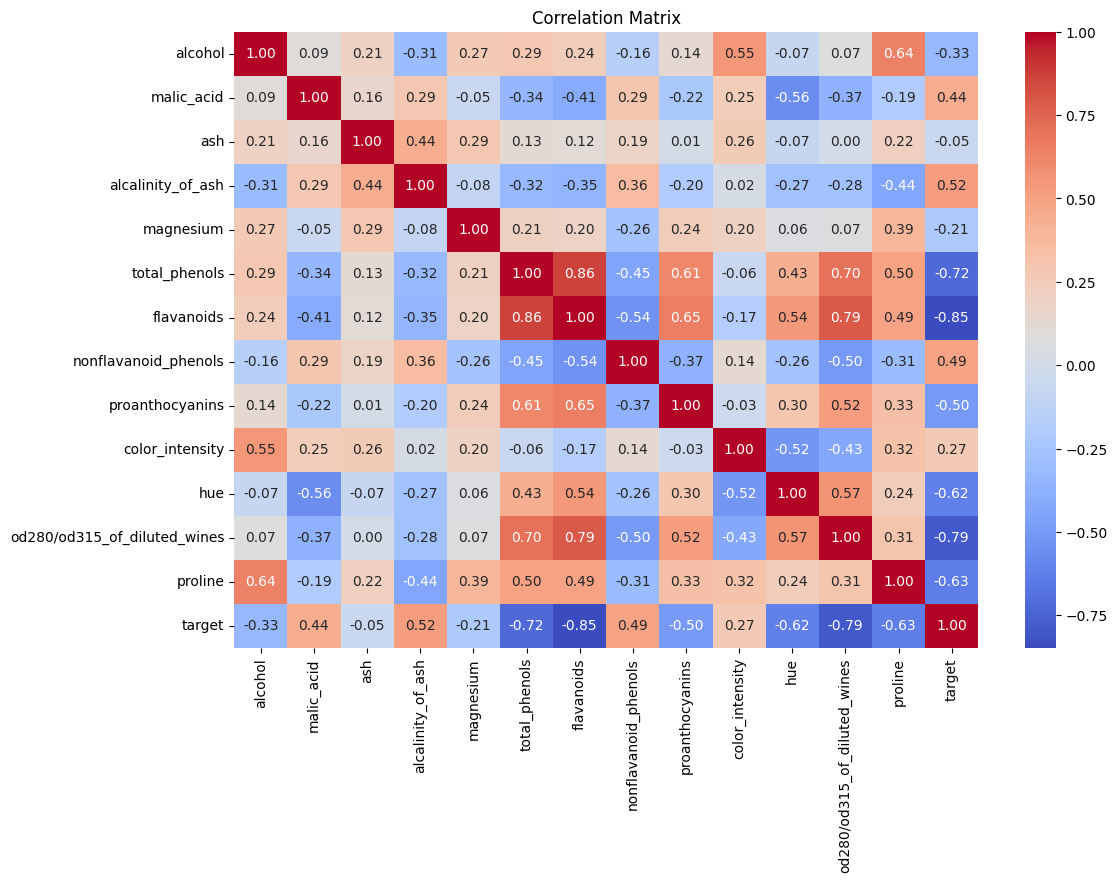

Top 3 most correlated pairs:
flavanoids - total_phenols: 0.865
total_phenols - flavanoids: 0.865
target - flavanoids: -0.847


In [7]:
#Creating correlation matrix

corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

corr_pairs = corr_matrix.unstack().sort_values(key=abs, ascending=False)
top_3_pairs = corr_pairs[(corr_pairs != 1.0) & (corr_pairs.abs() > 0.5)].head(3)
print("Top 3 most correlated pairs:")
for pair, value in top_3_pairs.items():
    print(f"{pair[0]} - {pair[1]}: {value:.3f}")


Top 3 most correlated pairs:

flavanoids - total_phenols: 0.865

total_phenols - flavanoids: 0.865

target - flavanoids: -0.847

İlk 3 çift, birbirleriyle en güçlü şekilde ilişkili olan işaretleri gösterir. Pozitif korelasyon, her iki işaretin birlikte büyüdüğü anlamına gelirken, negatif korelasyon birinin büyüdüğü, diğerinin azaldığı anlamına gelir.

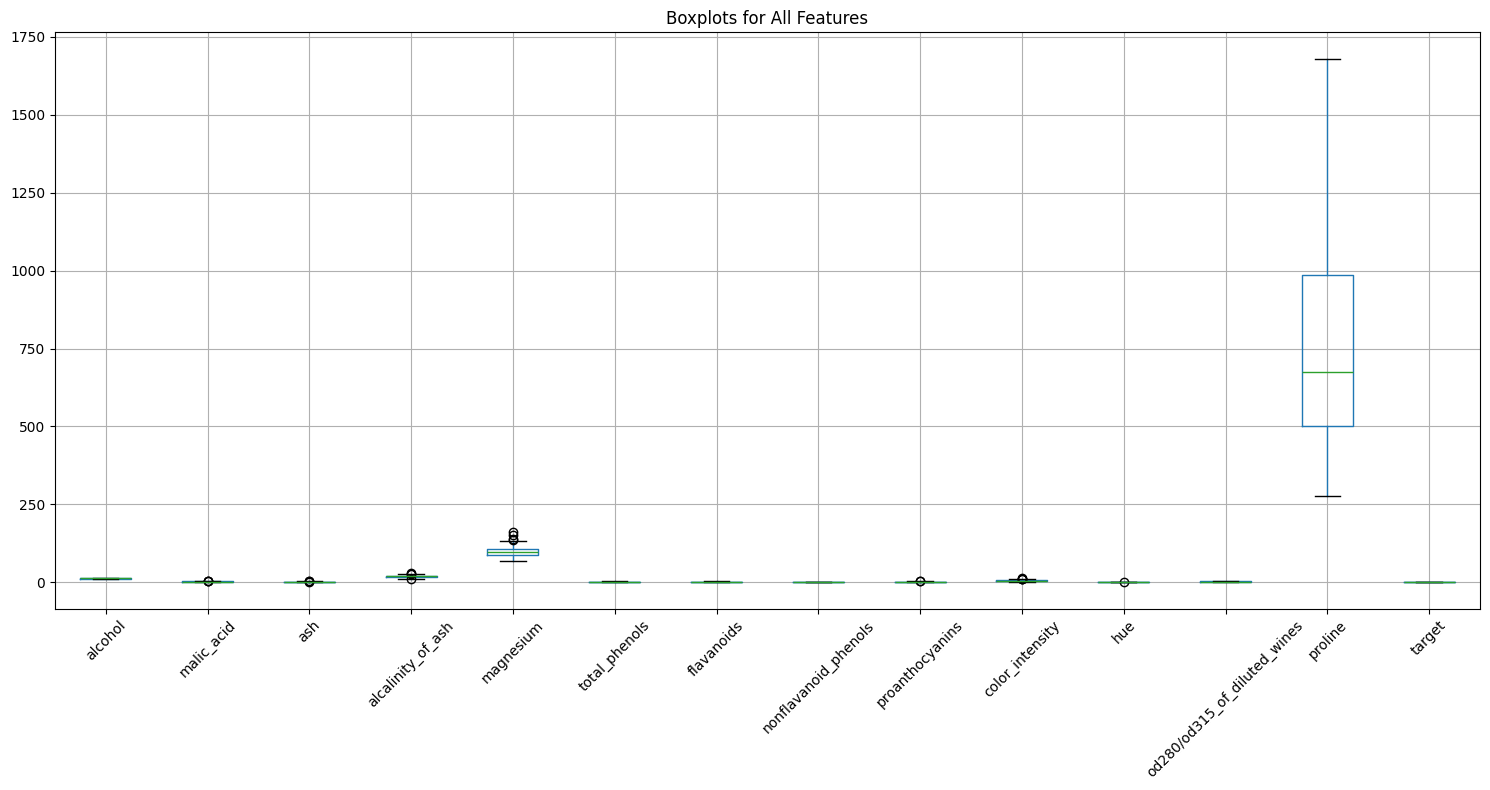

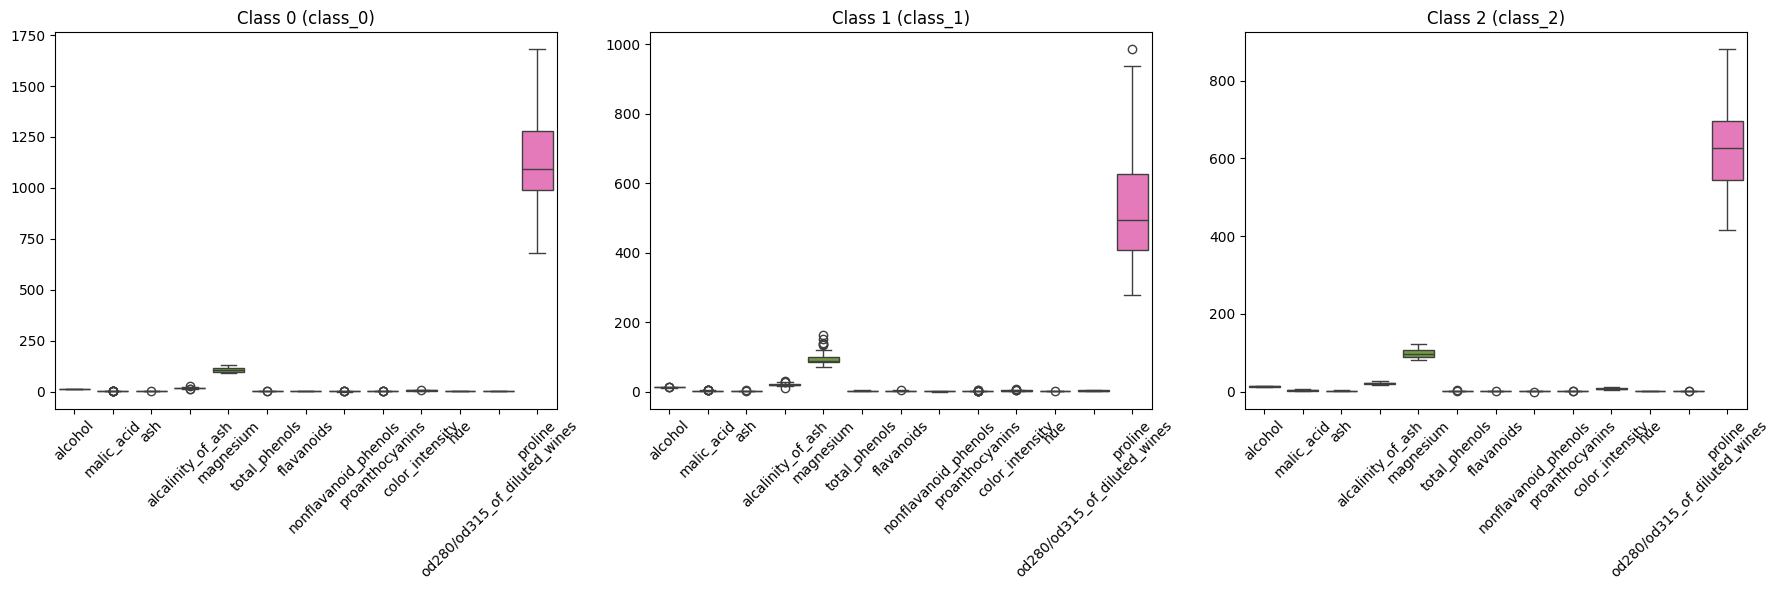

In [8]:
plt.figure(figsize=(15, 8))
df.boxplot()
plt.xticks(rotation=45)
plt.title('Boxplots for All Features')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, target_class in enumerate([0, 1, 2]):
    class_data = df[df['target'] == target_class].drop('target', axis=1)
    sns.boxplot(data=class_data, ax=axes[i])
    axes[i].set_title(f'Class {target_class} ({data.target_names[i]})')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Analiz
1. Prolin (proline)
*   Sınıf 0, en yüksek medyan proline değerine ve aynı zamanda en büyük dağılıma (en yüksek kutu ve en uzun bıyıklar/aykırı değerler) sahiptir. Medyan yaklaşık 800-1000 civarındadır.

*   Sınıf 1, en düşük medyan proline değerine (yaklaşık 350-400) ve daha küçük bir dağılıma sahiptir.

*   Sınıf 2, Sınıf 0'a kıyasla orta düzeyde bir medyan değere (yaklaşık 600-700) ve daha küçük bir dağılıma sahiptir.

Sonuç: Proline özelliği, dağılımları minimum düzeyde örtüştüğü ve medyanları çok farklı olduğu için üç sınıf arasındaki en güçlü ayırıcı faktördür.

2. Magnezyum (magnesium)
Sınıf 1, açıkça en yüksek medyan magnesium değerine (yaklaşık 100) ve belirgin aykırı değerlerle birlikte büyük bir dağılıma sahiptir.

*   Sınıf 0 ve Sınıf 2, çok benzer ve daha düşük medyan değerlerine (yaklaşık 80-90) ve daha küçük bir dağılıma sahiptir.

*   Sonuç: Magnesium özelliği, Sınıf 1'i Sınıf 0 ve 2'den iyi bir şekilde ayırır.

3. Külün Alkalinitesi (alkalinity_of_ash)
*   Sınıf 1, Sınıf 0 ve Sınıf 2'den (medyanlar yaklaşık 15-17) daha yüksek bir kül alkalinitesine (medyan yaklaşık 20) eğilimlidir.

*   Sonuç: Alkalinity_of_ash özelliği, özellikle Sınıf 1'in ayrılmasına katkıda bulunur, ancak dağılımları büyük ölçüde örtüşmektedir.

4. Diğer Özellikler
*   Geriye kalan özelliklerin çoğu (örneğin, alcohol, malic_acid, flavanoids, color_intensity, vb.), çok düşük değerlere ve sınıflar arasında yüksek düzeyde örtüşmeye sahiptir, bu da onları sınıfları tek başına açıkça ayırmak için daha az etkili kılar. Örneğin, alcohol ve malic_acid, her üç sınıfta da çok yakın medyanlara ve dağılımlara sahiptir ve bu ölçekte zorlukla ayırt edilebilirler.

Grafikler, Sınıf 0, 1 ve 2'nin kimyasal profillerinde istatistiksel olarak anlamlı farklılıklar olduğunu ve bunun onların sınıflandırılmasına olanak tanıdığını göstermektedir.

*   Prolin, üç sınıfın tamamını ayırmak için anahtar özelliktir.

*   Magnezyum ve külün alkalinitesi, Sınıf 1'i diğer ikisinden ayırmaya yardımcı olur.

# 4. Veri Ölçeklendirme (Scaling)

Aşağıdaki yaklaşımlardan biri kullanılabilir:

StandardScaler (önerilen)
MinMaxScaler
RobustScaler

Ölçeklendirilmiş veriyi X_scaled olarak kaydediniz.


In [ ]:
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X) #z = (x - u) / s where u is mean, s is standard diviation

#print(X_scaled[:3])

# 5. Veri Setinin Bölünmesi

Veri şu şekilde bölünecektir:

%70 Training

%10 Validation

%20 Test

Not: Validation için ikinci bir train_test_split kullanılabilir.


In [9]:
#split as follows: 70% Training, 10% Validation, 20% Test

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(2/3), random_state=42, stratify=y_temp)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_scaled = np.vstack([X_train_scaled, X_val_scaled, X_test_scaled])
print("\nX_scaled shape:", X_scaled.shape)


X_scaled shape: (178, 13)


# 6. Farklı MLP Modellerinin Kurulması

Aşağıdaki parametre kombinasyonlarıyla 5 farklı MLP modeli oluşturulacaktır:

**Model 1 – Basit**

hidden_layer_sizes=(16,)

activation="relu"

learning_rate_init=0.001

**Model 2 – Orta**

hidden_layer_sizes=(32, 16)

activation="relu"

learning_rate_init=0.005

**Model 3 – Geniş**

hidden_layer_sizes=(64, 64)

activation="tanh"

learning_rate_init=0.001

**Model 4 – Derin**

hidden_layer_sizes=(128, 64, 32)

activation="relu"

learning_rate_init=0.0005

**Model 5 – Düşük Öğrenme Oranlı**

hidden_layer_sizes=(32,)

activation="relu"

learning_rate_init=0.0001


In [10]:
model1 = MLPClassifier(
    hidden_layer_sizes=(16,),
    activation="relu",
    learning_rate_init=0.001,
    max_iter=1000,
    solver="adam",
    random_state=42
)

# Training
model1.fit(X_train_scaled, y_train)

# Prediction
y_val_pred = model1.predict(X_val_scaled)
y_test_pred = model1.predict(X_test_scaled)


In [11]:
model2 = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    learning_rate_init=0.005,
    solver="adam",
    max_iter=1000,
    random_state=42
)

model2.fit(X_train_scaled, y_train)

y_val_pred2 = model2.predict(X_val_scaled)
y_test_pred2 = model2.predict(X_test_scaled)

In [12]:
model3 = MLPClassifier(
    hidden_layer_sizes=(64, 64),
    activation="tanh",
    learning_rate_init=0.001,
    solver="adam",
    max_iter=1000,
    random_state=42
)

model3.fit(X_train_scaled, y_train)
y_val_pred3 = model3.predict(X_val_scaled)
y_test_pred3 = model3.predict(X_test_scaled)

In [13]:
model4 = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation="relu",
    learning_rate_init=0.0005,
    solver="adam",
    max_iter=1200,
    random_state=42
)

model4.fit(X_train_scaled, y_train)
y_val_pred4 = model4.predict(X_val_scaled)
y_test_pred4 = model4.predict(X_test_scaled)

In [14]:
model5 = MLPClassifier(
    hidden_layer_sizes=(32,),
    activation="relu",
    learning_rate_init=0.0001,
    solver="adam",
    max_iter=2500,
    random_state=42
)

model5.fit(X_train_scaled, y_train)
y_val_pred5 = model5.predict(X_val_scaled)
y_test_pred5 = model5.predict(X_test_scaled)

# 7. Validation Performanslarının Ölçülmesi
Her model validation seti üzerinde aşağıdaki metrikler ile değerlendirilecektir:

Accuracy

Precision

Recall

F1-Score

ROC-AUC

Tüm modellerin performanslarını bir tablo hâlinde karşılaştırınız.


In [15]:
def evaluate_model(model, Xv, yv):
    y_pred = model.predict(Xv)
    y_proba = model.predict_proba(Xv)

    return {
        "Accuracy": accuracy_score(yv, y_pred),
        "Precision": precision_score(yv, y_pred, average='weighted'),
        "Recall": recall_score(yv, y_pred, average='weighted'),
        "F1-Score": f1_score(yv, y_pred, average='weighted'),
        "ROC-AUC": roc_auc_score(yv, y_proba, multi_class='ovr', average='weighted')
    }

In [16]:
all_results = {
    "Model 1 (Simple)": evaluate_model(model1, X_val_scaled, y_val),
    "Model 2 (Medium)": evaluate_model(model2, X_val_scaled, y_val),
    "Model 3 (Wide)":   evaluate_model(model3, X_val_scaled, y_val),
    "Model 4 (Deep)":   evaluate_model(model4, X_val_scaled, y_val),
    "Model 5 (Low LR)": evaluate_model(model5, X_val_scaled, y_val),
}

comparison_df = pd.DataFrame(all_results).T

print("\nMeasuring Validation Performance\n")
print(comparison_df)


Measuring Validation Performance

                  Accuracy  Precision    Recall  F1-Score   ROC-AUC
Model 1 (Simple)  0.888889   0.896825  0.888889  0.887939  0.985269
Model 2 (Medium)  0.888889   0.896825  0.888889  0.887939  0.989899
Model 3 (Wide)    1.000000   1.000000  1.000000  1.000000  1.000000
Model 4 (Deep)    0.944444   0.951389  0.944444  0.943210  1.000000
Model 5 (Low LR)  1.000000   1.000000  1.000000  1.000000  1.000000


# 8. En İyi Modelin Test Üzerinde Değerlendirilmesi
Validation sonuçlarına göre en iyi modeli seçiniz.

Bu model için test seti üzerinde:

8.1 Performans Metrikleri

Accuracy

Precision

Recall

F1-score

ROC-AUC

8.2 Confusion Matrix

seaborn heatmap ile çiziniz.

8.3 ROC Eğrisi

ROC curve + AUC değeri

Eşik değerinin performansa etkisini yorumlayın.


In [17]:
# Selecting the best model based on validation results
best_model = model5
best_model_name = "Model 5 (Low LR)"

print(f"the best model: {best_model_name}")
print(f"Validation Accuracy: {comparison_df.loc[best_model_name, 'Accuracy']:.4f}")

# 8.1 Metrics on the test dataset
y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)

test_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred, average='weighted'),
    "Recall": recall_score(y_test, y_test_pred, average='weighted'),
    "F1-Score": f1_score(y_test, y_test_pred, average='weighted'),
    "ROC-AUC": roc_auc_score(y_test, y_test_proba, multi_class='ovr', average='weighted')
}

print("\nMetrics on the test dataset:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_test_pred, target_names=data.target_names))

the best model: Model 5 (Low LR)
Validation Accuracy: 1.0000

Metrics on the test dataset:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000

Classification report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



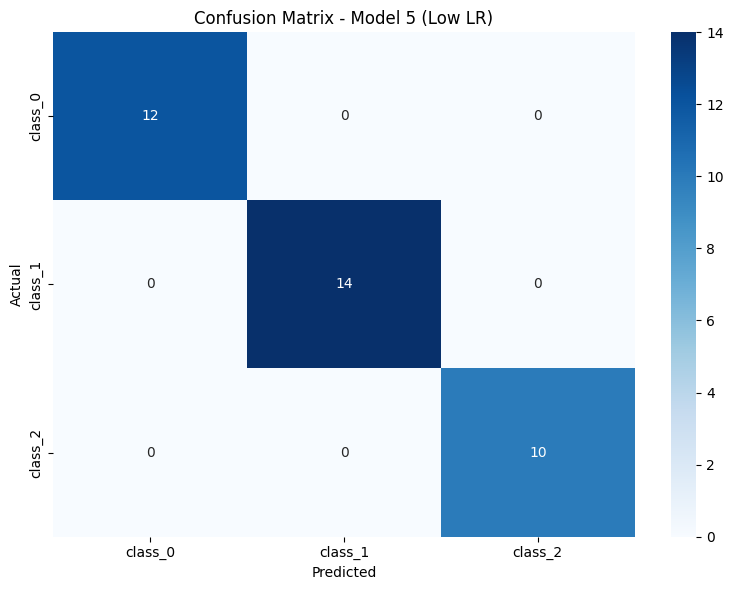

In [18]:
# 8.2 Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=data.target_names,
            yticklabels=data.target_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

**Sınıflandırma Sonuçları**

Model 5 Low Learning Rate bu veri kümesinde mükemmel bir performans sergilemiştir, çünkü diyagonal olmayan tüm öğeler sıfıra eşittir, bu da sınıflandırma hatası olmadığı anlamına gelir.

Sınıf 0 (class_0):

Gerçekte Sınıf 0'a ait olanlar: 12

Sınıf 0 olarak Doğru Tahmin Edilenler: 12

Sınıf 1 veya 2 olarak Yanlış Tahmin Edilenler: 0

Sınıf 1 (class_1):

Gerçekte Sınıf 1'e ait olanlar: 14

Sınıf 1 olarak Doğru Tahmin Edilenler: 14

Sınıf 0 veya 2 olarak Yanlış Tahmin Edilenler: 0

Sınıf 2 (class_2):

Gerçekte Sınıf 2'ye ait olanlar: 10

Sınıf 2 olarak Doğru Tahmin Edilenler: 10

Sınıf 0 veya 1 olarak Yanlış Tahmin Edilenler: 0

Veri kümesindeki toplam nesne sayısı tüm doğru tahminlerin toplamına eşittir: 12 + 14 + 10 = 36 nesne.

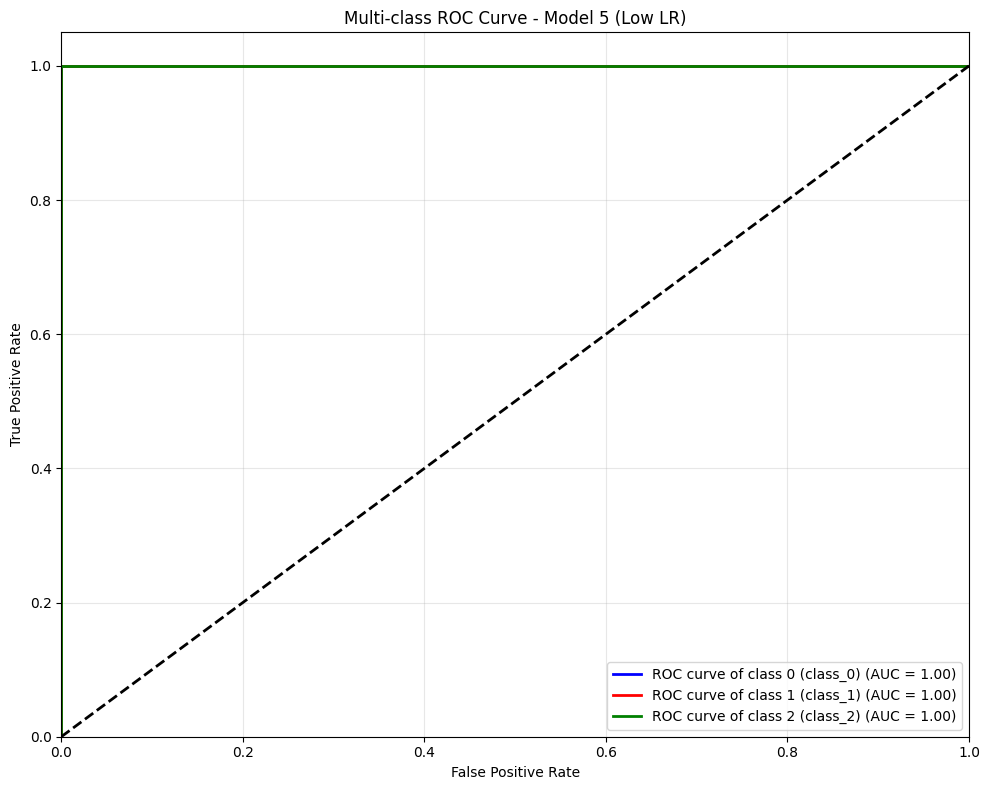

• Averange AUC: 1.000


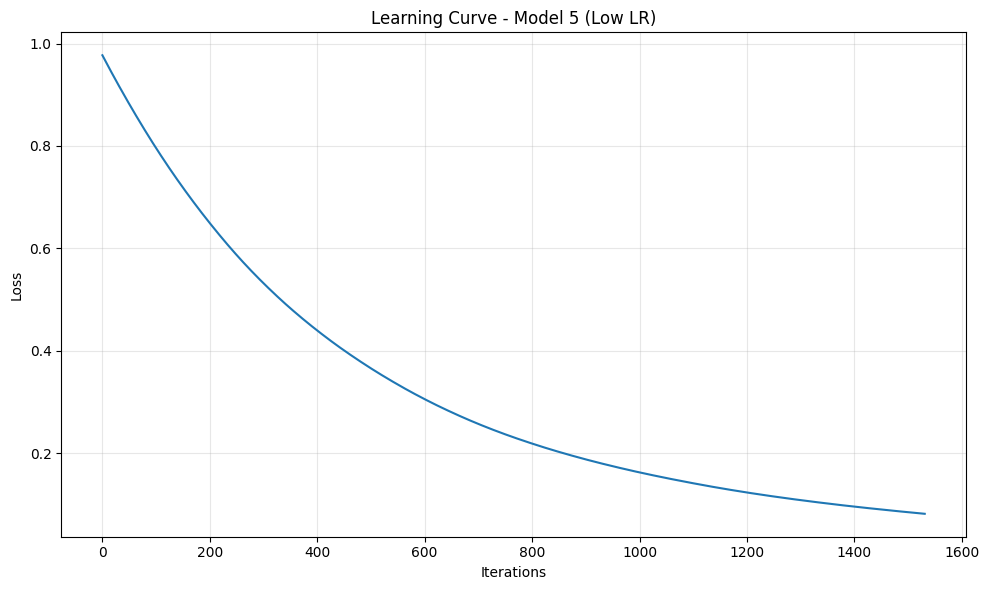

In [19]:
# 8.3 ROC Curve
# converts multiclass labels to the "one-vs-rest" binary format
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# а separate ROC curve is constructed for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plotting ROC Curve
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} ({1}) (AUC = {2:0.2f})'
             .format(i, data.target_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Multi-class ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Analyzing
print(f"• Averange AUC: {np.mean(list(roc_auc.values())):.3f}")

# Learning curve
if hasattr(best_model, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(best_model.loss_curve_)
    plt.title(f'Learning Curve - {best_model_name}')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Açıklaması

ROC Curve

Üç sınıfın (class_0, class_1, class_2) ROC eğrileri, grafiğin üst sınırında mükemmel bir şekilde yer almaktadır; yani, FPR=0 iken TPR=1.
AUC (Eğri Altındaki Alan) değerinin 1.00 olması, ideal sınıflandırma anlamına gelir. Model, her bir sınıf için pozitif nesneleri negatif nesnelerden kusursuz bir şekilde ayırabilir. Bu sonuç, Karışıklık Matrisinden (Confusion Matrix) çıkarılan, modelin bu veri kümesinde sıfır sınıflandırma hatası yaptığı sonucunu doğrulamaktadır.

Learning Curve

Grafik, iterasyonların başlangıcındaki maksimum değerden (yaklaşık 1.0) başlayarak ve eğitimin sonuna (1500+ iterasyon) doğru sıfıra (yaklaşık 0.05) yaklaşarak, kayıp fonksiyonunda (Loss) hızlı ve istikrarlı bir düşüş göstermektedir. Algoritma, düşük öğrenme hızıyla (Low LR) iyi bir yakınsama (convergence) sergilemektedir.

# 9. Optuna ile Hiperparametre Optimizasyonu (150 Deneme)
9.1 Optuna Study Tanımı

direction="maximize"

metric: validation accuracy veya F1-score

9.2 Optuna Arama Aralıkları

```
# This is formatted as code
hidden_layer_sizes:    (trial.suggest_int(16, 256), trial.suggest_int(8, 128))
learning_rate_init:    trial.suggest_loguniform(1e-5, 1e-1)
alpha:    trial.suggest_loguniform(1e-6, 1e-2)
activation:    trial.suggest_categorical(["relu", "tanh"])
solver:    trial.suggest_categorical(["adam", "sgd"])
batch_size:    trial.suggest_categorical([16, 32, 64, 128])
```

9.3 Eğitim Döngüsü

Her trial bir MLPClassifier modeli kurup eğitir.

Validation skorunu geri döndürür.

9.4 En İyi Trial’ın Raporlanması

En iyi parametre setini yazdırınız.

Validation metriklerini gösteriniz.


In [20]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 24.5 MB/s eta 0:00:00


In [21]:
# 9.1 Define Objective Function
import optuna

def objective(trial):
    """
    Objective function for Optuna
    Trains an MLP model for each trial and returns validation accuracy
    """

    # 9.2 Hyperparameter search ranges
    hidden_layer_sizes = (trial.suggest_int('layer1_size', 16, 256), trial.suggest_int('layer2_size', 8, 128))

    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-1, log=True)
    alpha = trial.suggest_float('alpha', 1e-6, 1e-2, log=True)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # 9.3 Model creation and training
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        batch_size=batch_size,
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20
    )

    try:
        # Train model
        model.fit(X_train_scaled, y_train)

        # Validation predictions
        y_val_pred = model.predict(X_val_scaled)

        # Calculate accuracy and F1-score
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')

        # Optimize F1-score
        return val_f1

    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=150)

print("Best F1-score:", study.best_value)
print("Best params:", study.best_params)


[I 2025-11-30 09:20:21,603] A new study created in memory with name: no-name-24808ee0-83c0-492d-b67f-684a35cd616a
[I 2025-11-30 09:20:22,004] Trial 0 finished with value: 0.8337865837865839 and parameters: {'layer1_size': 106, 'layer2_size': 123, 'learning_rate_init': 0.008471801418819975, 'alpha': 0.0002481040974867811, 'activation': 'relu', 'solver': 'sgd', 'batch_size': 128}. Best is trial 0 with value: 0.8337865837865839.
[I 2025-11-30 09:20:22,250] Trial 1 finished with value: 0.778943278943279 and parameters: {'layer1_size': 216, 'layer2_size': 33, 'learning_rate_init': 5.3370327626039544e-05, 'alpha': 5.415244119402541e-06, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 16}. Best is trial 0 with value: 0.8337865837865839.
[I 2025-11-30 09:20:22,525] Trial 2 finished with value: 0.8263888888888888 and parameters: {'layer1_size': 125, 'layer2_size': 103, 'learning_rate_init': 6.290644294586152e-05, 'alpha': 0.00011400863701127338, 'activation': 'relu', 'solver': 'adam', 'ba

Best F1-score: 1.0
Best params: {'layer1_size': 242, 'layer2_size': 123, 'learning_rate_init': 0.04565176372646328, 'alpha': 3.0243691612726458e-05, 'activation': 'tanh', 'solver': 'sgd', 'batch_size': 16}


Optuna çatısı kullanılarak yapılan otomatik hiperparametre optimizasyonu sürecinde. Bu denemelerin (trial) her birinin içinde aşağıdaki eylem dizisi gerçekleştirilir:

**Modelin İnşası ve Eğitimi**

model.fit(X_train_scaled, y_train)

**Modelin Doğrulama Kümesinde Değerlendirilmesi**

y_val_pred = model.predict(X_val_scaled)

**İki temel performans metriği hesaplanır:**

val_accuracy ve val_f1

Optuna bağlamında ve genel olarak hiperparametre optimizasyonu görevlerinde, farklı denemeler (trial'lar) arasında "ince ayar" (fine-tuning) veya "eğitime devam etme" (continuation of training) kullanılmaz.

** Optuna Neden Eğitime Devam Etmez?**

Optuna'nın Amacı Karşılaştırmadır: Optuna'nın ana görevi, en iyi hiperparametre kombinasyonunu (örneğin, alpha, learning_rate_init, hidden_layer_sizes) bulmaktır. Örneğin, A kombinasyonunu (küçük alpha ile) B kombinasyonuyla (büyük alpha ile) dürüstçe karşılaştırmak için, her modelin sıfırdan ve bağımsız olarak eğitilmesi gerekir.

In [22]:
# 9.4 Reporting the Best Trial
print("\n Best parameters:")
print("-" * 70)
best_params = study.best_params
for param, value in best_params.items():
    print(f"  • {param}: {value}")

print(f"\nBest Validation F1-Score: {study.best_value:.4f}")
print(f"Best Trial Number: {study.best_trial.number}")


 Best parameters:
----------------------------------------------------------------------
  • layer1_size: 242
  • layer2_size: 123
  • learning_rate_init: 0.04565176372646328
  • alpha: 3.0243691612726458e-05
  • activation: tanh
  • solver: sgd
  • batch_size: 16

Best Validation F1-Score: 1.0000
Best Trial Number: 20


In [23]:
# 9.4 Reporting the Best Trial
print(f"\n Validation metrics:")
print("-" * 70)

# create the model with best parameters
best_model = MLPClassifier(
    hidden_layer_sizes=(best_params['layer1_size'], best_params['layer2_size']),
    activation=best_params['activation'],
    solver=best_params['solver'],
    learning_rate_init=best_params['learning_rate_init'],
    alpha=best_params['alpha'],
    batch_size=best_params['batch_size'],
    max_iter=1000,
    random_state=42,
    early_stopping=False
)

# train the model
best_model.fit(X_train_scaled, y_train)
y_val_pred = best_model.predict(X_val_scaled)

print(f"  Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"  Precision: {precision_score(y_val, y_val_pred, average='weighted'):.4f}")
print(f"  Recall: {recall_score(y_val, y_val_pred, average='weighted'):.4f}")
print(f"  F1-Score: {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
print(f"  Best Trial F1-Score: {study.best_value:.4f}")


 Validation metrics:
----------------------------------------------------------------------
  Accuracy: 0.9444
  Precision: 0.9514
  Recall: 0.9444
  F1-Score: 0.9432
  Best Trial F1-Score: 1.0000


Sonuç:

Hiperparametre optimizasyonu başarılı bir şekilde tamamlanmıştır ve doğrulama kümesinde son derece yüksek bir metrik (F1-Score: 1.0000) sağlayan parametre kombinasyonlarını bulmaya olanak tanımıştır.

Ancak, en iyi denemenin metrikleri ile bu parametrelere sahip eğitilmiş modelin (muhtemelen başka veya nihai) doğrulama/test kümesindeki metriklerinin karşılaştırılması, potansiyel aşırı uydurma (overfitting) olduğunu göstermektedir.

# 10. XAI – SHAP Açıklanabilirlik Analizi (Zorunlu)

Bu bölümde modellerinizin nasıl karar verdiğini açıklayacaksınız.

**10.1 Beş MLP Modelinden validasyon başarısına göre seçilen model için SHAP Analizi**

En iyi  model için:

SHAP Explainer oluşturun

summary_plot gösterin

bar_plot (feature importance) çizdirin

En baskın özellikleri yorumlayın

Model performansı ve SHAP önem sıralaması arasındaki ilişkiyi tartışın

**10.2 Optuna En İyi Model için SHAP Analizi**

Aşağıdaki SHAP görselleştirmeleri yapılacaktır:

summary_plot (dots) → tüm verideki önem sıralaması

bar_plot → ortalama etki büyüklükleri

force_plot → tek bir örnek için karar açıklaması

decision_plot → karar yolunun özellere göre katkısı

**Sonuçları yorumlayınız:**

Hangi özellikler kararları belirledi?

Optuna’nın bulduğu model hangi özelliklere daha duyarlı?

MLP modellerindeki ortak ve farklı SHAP paternleri neler?



Bu bölümün analizi, iki anahtar model üzerinde gerçekleştirilecektir: doğrulama (validation) metriğine göre ilk beş MLPClassifier modeli arasından seçilen en iyi model (Model 5) ve Optuna kullanılarak yapılan otomatik hiperparametre optimizasyonu sonucunda elde edilen küresel olarak en iyi model.

In [ ]:
import shap

# Calculating SHAP values for the model5
explainer = shap.KernelExplainer(model5.predict_proba, X_train_scaled)
shap_values = explainer.shap_values(X_val_scaled)

In [ ]:
# Create summary plot
shap.initjs()
shap.summary_plot(shap_values, X_val_scaled, feature_names=list(X.columns))

Grafik, üç özellik (alcohol, malic_acid ve ash) arasındaki etkileşimi göstermektedir.

**Etkileşimin Yorumlanması (Sütunlara Göre)**

**Köşegen Hücreler (Diagonal Cells)**

Bu hücreler teknik olarak "ana etkiyi" (main effect) gösterir, saf etkileşimi değil. Ancak bu tür grafiklerde genellikle özelliğin SHAP değerini göstermek için kullanılırlar.

alcohol (alcohol satırı, alcohol sütunu): Yüksek alcohol değeri (kırmızı noktalar), genellikle pozitif bir SHAP değeri (sağa kayma) ile ilişkilidir; düşük değerler (mavi) ise negatif bir SHAP değeri (sola kayma) ile ilişkilidir. Bu, yüksek alcohol seviyesinin tek başına tahmini artırdığı (ve tersi) anlamına gelir.

**alcohol ve malic_acid Etkileşimi (alcohol-malic_acid)**

İlgili hücreye bakıyoruz: alcohol satırı, malic_acid sütunu.

Noktaların çoğunlukla 0 civarında kümelendiği görülüyor.

Az sayıda kırmızı nokta (yüksek malic_acid), 0'ın sağında yer alıyor. Bu, hem alcohol hem de malic_acid yüksek değerlere sahip olduğunda, ortak etkilerinin hafifçe pozitif olabileceğini (tahmini güçlendirdiğini) gösterebilir.

**ash ve alcohol Etkileşimi (ash-alcohol)**

İlgili hücreye bakıyoruz: ash satırı, alcohol sütunu.

Burada da noktaların çoğu 0 civarındadır.

Bazı kırmızı noktalar (yüksek alcohol) ve mavi noktalar (düşük alcohol), küçük bir negatif veya pozitif SHAP etkileşim değerine sahiptir. alcohol düşükken (mavi) ve ash değişirken, etkileşim biraz daha negatif (sola kayma) gibi görünüyor, ancak genel etkileşim etkisi küçüktür.

**malic_acid ve ash Etkileşimi (malic_acid-ash)**

İlgili hücreye bakıyoruz: malic_acid satırı, ash sütunu.

Noktaların büyük bir kısmı sıfırda yoğunlaşmıştır. Bu, malic_acid ve ash arasındaki etkileşimin modelin tahmini üzerinde minimum düzeyde etkiye sahip olduğunu gösterir.

**Genel Sonuç**

Grafik şunu gösteriyor:

Özelliklerin ana etkisi (köşegen) en belirgin olanıdır: alcohol, malic_acid ve ash özellikleri tek başlarına tahmin üzerinde önemli bir etkiye sahiptir.

Özellik çiftleri arasındaki etkileşimler (alcohol-malic_acid, alcohol-ash, malic_acid-ash) ana etkilerine kıyasla zayıftır (noktaların çoğu 0'a çok yakındır). Bu, bir özelliğin tahmin üzerindeki etkisinin, o çiftteki diğer özelliğin değerine büyük ölçüde bağlı olmadığı anlamına gelir.

In [ ]:
# Create bar plot
expl = shap.Explanation(shap_values[1], explainer.expected_value[1], X_val_scaled, feature_names = list(X.columns))
shap.plots.bar(expl)

0th alcohol olarak adlandırılan özellik, bu üç kategori/sınıf arasında en önemli olanıdır veya tahmin üzerinde en büyük ortalama etkiye sahiptir; buna karşılık 2nd alcohol ise en az etkiye sahiptir.

In [ ]:
# additional bar plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_val_scaled, feature_names=list(X.columns), plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Model 5")
plt.tight_layout()
plt.show()

Özelliklerin Genel Önemi (Çubuk Uzunluğu)
Modele en büyük genel etkiyi yapan en önemli özellikler (en uzun çubuklar) şunlardır:

alcohol: Modeldeki açık ara en önemli özelliktir.

ash

od280/od315_of_diluted_wines (Muhtemelen şarabın saflığının bir ölçüsüdür)

proline

En az önemli özellikler: magnesium, proanthocyanins, nonflavanoid_phenols.

Model, şarapları sınıflandırmak için temel olarak alcohol, ash ve od280/od315_of_diluted_wines özelliklerine dayanmaktadır. Bu özelliklerin etkisi farklı sınıflar için aynı değildir: örneğin, Class 0'ı ayırt etmek için model çoğunlukla alcohol seviyesine bakarken, Class 2'yi ayırt etmek için od280/od315 göstergesine bakar.

# 10.2 SHAP Analysis for Optuna Best Model

In [ ]:
# Calculating SHAP values for the Optuna best_model
explainer = shap.KernelExplainer(best_model.predict_proba, X_train_scaled)
shap_values = explainer.shap_values(X_val_scaled)

In [ ]:
# Create summary plot
shap.summary_plot(shap_values, X_val_scaled, feature_names=X.columns)

Optuna kullanılarak optimize edilmiş model, alcohol ve malic_acid özellikleri arasında olağanüstü güçlü bir etkileşim sergilemektedir.

Bu, alcohol ve malic_acid'in etkisinin ayrı ayrı analiz edilemeyeceği anlamına gelir. Model, bu iki özelliğin kombinasyonunu güçlü bir öngörücü olarak kullanmayı öğrenmiştir; burada bir özelliğin etkisi, diğerinin değeri tarafından ya güçlendirilmekte ya da zayıflatılmaktadır.

In [ ]:
# Create bar plot
expl = shap.Explanation(shap_values[1], explainer.expected_value[1], X_val_scaled, feature_names = X.columns)
shap.plots.bar(expl)

Bu grafik, optimize edilmiş modelde 'alcohol' özelliğinin üç farklı sınıf/kategori (0th, 1st, 2nd) üzerindeki tahmin için olan ortalama mutlak etkisini (mean(|SHAP value|)) göstermektedir.

**Yorumlama**

- 0th alcohol: En büyük ortalama mutlak etkiye (+0.05) sahiptir. Bu, alcohol özelliğinin Sınıf 0'ı ayırt etme veya tahmin etme girişiminde model için en kritik olduğu anlamına gelir.

- 1st alcohol: Neredeyse aynı büyük ortalama mutlak etkiye (+0.05) sahiptir. Bu, alcohol özelliğinin Sınıf 1'i ayırt etmek veya tahmin etmek için de çok önemli olduğu anlamına gelir.

- 2nd alcohol: En düşük ortalama mutlak etkiye (+0.02) sahiptir. Bu, Sınıf 2 tahmininde (diğer sınıflara kıyasla) modelin ortalama olarak alcohol özelliğine daha az güvendiğini gösterir.

**X Ekseni Değerleri ile Sağdaki Etiketler Arasındaki Uyumsuzluk**

**Grafiğe dikkatlice bakıldığında:**

- 0th alcohol" çubuğu, +0.05 değerine karşılık gelecek şekilde X ekseninin en sonuna ulaşır. Burada etiket ve çubuk uyumludur.

- 1st alcohol" çubuğu, "0th alcohol" çubuğundan açıkça daha kısadır ve yaklaşık olarak 0.045 seviyesinde durmaktadır. Ancak sağdaki etiket +0.05 göstermektedir.

- 2nd alcohol" çubuğu yaklaşık 0.02'de durur ve bu da +0.02 etiketiyle uyumludur.

**Sonuç:**

1st alcohol etkisinin sayısal olarak +0.05 olarak yuvarlanmasına rağmen, görsel olarak 0th alcohol'ün etkisinden (örneğin 0.051 olabilir) biraz daha küçüktür. Bununla birlikte, yorumlama amacıyla 0th alcohol ve 1st alcohol'ü eşit derecede önemli özellikler olarak kabul ederiz, çünkü ortalama etkileri aynı yuvarlanmış değer içindedir ve her ikisi de modeldeki baskın faktörlerdir.

In [ ]:
# Recreate explainer for multi-output predict_proba
explainer_multi_output = shap.KernelExplainer(best_model.predict_proba, X_train_scaled)

# Select a single instance from the original DataFrame
single_instance_original = X.iloc[[169]]
# Scale the single instance
single_instance_scaled = scaler.transform(single_instance_original)

# Calculate SHAP values for all classes for this single instance
shap_values_all_classes_single_instance = explainer_multi_output.shap_values(single_instance_scaled)

# Ensure feature_names are available
wine = load_wine()
feature_names = wine.feature_names

# Choose the class to plot
class_to_plot = 1

# Plotting the force plot for the single instance for a specific class
print(f"SHAP Force Plot for a single instance (X.iloc[169, :]) for Class {class_to_plot}:")
shap.initjs()
shap.force_plot(explainer_multi_output.expected_value[class_to_plot], # Expected value for the specific class
                shap_values_all_classes_single_instance[0, :, class_to_plot], # SHAP values for the specific class, for the first (and only) sample
                single_instance_scaled[0], # Feature values for the single sample
                feature_names=feature_names)

Bu grafik, sınıflandırma görevindeki tek bir somut örnek (instance) (indeks 169) ve tek bir belirli sınıf (Sınıf 1) için bir SHAP Kuvvet Grafiğini (Force Plot) temsil etmektedir.

Amacı, bu spesifik örnekteki her bir özelliğin, modelin tahminini Sınıf 1 için Temel Değerden (Base Value) Nihai Tahmine (Output Value) doğru nasıl kaydırdığını açıklamaktır.

**Anahtar Öğeler**

- Temel Değer (Base Value): Ortada gösterilir (yaklaşık 0.4033). Bu, eğitim veri setinin tamamı için Sınıf 1'in ortalama beklenen model çıktısı değeridir (log-odds veya olasılıklar cinsinden).

- Çıktı Değeri (Output Value): Yatay ölçekte sol tarafta gösterilir (100% işaretinin bulunduğu kırmızı/mavi alanın bitiş noktası). Bu, modelin bu örnek ve Sınıf 1 için yaptığı fiili tahmindir (yaklaşık -0.1967).

- Özellikler (Features):

  - Kırmızı Oklar/Etiketler: Tahmini artıran (sağa doğru kaydıran, yani -0.1998'den temel değer 0.4002'ye doğru iten) özelliklerdir.

  - Mavi Oklar/Etiketler: Tahmini azaltan (sola doğru kaydıran) özelliklerdir.

**Yorumlama**

Yatay çizgi, Temel Değerden nihai tahmine giden "yolu" gösterir:

- Temel Değer (Base Value) 0.4033'dir.

- Bu örnek için Fiili Tahmin (Sınıf 1) -0.1967'de sona ermektedir.

Model, nihai değer (-0.1967) Temel Değerden (0.4033) belirgin şekilde düşük olduğu için bu örneğin Sınıf 1'e ait olmadığını tahmin etmektedir.

**Özellik Katkısı:**

Tahmini azaltmaya en çok katkıda bulunan özellikler (mavi, sola çekenler):

flavanoids = 1.101 (En güçlü azaltıcı etkiyi gösterir).

proanthocyanins

alcohol = 12.83

hue = 1.23

Tahmini artırmaya en çok katkıda bulunan özellikler (kırmızı, sağa çekenler):

alcalinity_of_ash = 15.1 (Güçlü artırıcı etki).

color_intensity = 1.478

ash = 1.62

**Sonuç:**

Bu özel örnek için:

Yüksek flavanoids, proanthocyanins ve alcohol değerleri, Sınıf 1'e ait olma olasılığını güçlü bir şekilde düşürmüştür.

alcalinity_of_ash, color_intensity ve ash'in belirli değerleri, Sınıf 1'e ait olma olasılığını yükseltmeye çalışmıştır.

Ancak, tahmini azaltan özelliklerin toplam etkisi belirgin şekilde daha güçlü olmuş ve sonuç olarak Sınıf 1 için nihai tahmin (-0.1967) ortalama temel değerin oldukça altında kalmıştır.

In [ ]:
shap.initjs()

#contribution of each feature to the model's prediction for one specific instance.
i = 0 # for instance with index 0
class_id = 1

shap.force_plot(explainer.expected_value[class_id], shap_values[i, :, class_id], X_val_scaled[i], feature_names=X.columns)

**Özellik Katkısı:**

Tahmini azaltmaya en çok katkıda bulunan özellikler (mavi, sola çekenler):

malic_acid = 1.736: Çok güçlü bir azaltıcı etki gösterir.

hue = -1.675 (Bu negatif değer, ya verilerdeki ya da kodlamadaki bir hataya işaret ediyor olabilir ya da sadece hue özelliğinin çok düşük bir değerde olduğunu gösteriyordur).

flavanoids = 1.207

ash = 0.06168

**Tahmini artırmaya en çok katkıda bulunan özellikler (kırmızı, sağa çekenler):**

proline = -1.6745 (Dikkat edin, proline'ın düşük değeri tahmini artırıyor. Bu, düşük proline seviyesinin Sınıf 1 için pozitif bir öngörücü olduğu anlamına gelir).

alcohol = 1.094

color_intensity = 1.693

**Sonuç:**

Tahmini azaltan özelliklerin (özellikle malic_acid) kümülatif etkisi, artıran özelliklerin etkisinden çok daha ağır bastı. Bu durum, Sınıf 1 için nihai tahminin çok düşük olmasına yol açmıştır.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_val_scaled)

#This shows how each feature shifted the model's prediction from the base value for a single instance. The numbers are the contribution of each feature.

Bu, SHAP Kuvvet Grafiğinin dinamik veya özetlenmiş bir görünümüdür (SHAP Force Plot). Modelin tahminlerinin çok sayıda veri örneği üzerinde nasıl değiştiğini gösterir.

**Anahtar Öğeler**

Yatay Eksen (X): Tahminlerin benzerliğine göre sıralanmış örneklerin indeksi (genellikle tahmin edilen f(x) değerinin azalan veya artan sırasına göre).

Dikey Eksen (Y): f(x). Bu, her örnek için modelin fiili tahmin edilen değeridir (log-odds veya olasılıklar cinsinden).

Renkler ve Katmanlar: Farklı renkler, farklı özelliklerin tahmine olan katkısını temsil eder.

Kırmızı Alanlar: f(x) tahminini artıran özellikler (pozitif katkı).

Mavi Alanlar: f(x) tahminini azaltan özellikler (negatif katkı).

Katman Genişliği: Belirli bir renkteki katman ne kadar geniş (kalın) ise, o özelliğin tahmine katkısı o kadar büyüktür.

Feature 0 ve Feature 12 Etiketleri: Katkıları genel resmi oluşturan en önemli özelliklere işaret eder.

**Yorumlama**

1. Tahminlerin Genel Dinamiği

Sol Kısım (Örnekler 0 ila 11): f(x) tahmini (dikey eksen) 0.7305 ile 0.1303 aralığındadır. Burada mavi katmanlar (azaltıcı özellikler) baskındır veya önemli bir genişliğe sahiptir, bu da bu örneklerin çoğu için özelliklerin belirgin bir negatif katkı sağladığını gösterir.

Sağ Kısım (Örnekler 12 ila 16): f(x) tahmini keskin bir şekilde yükselir (1.131'e kadar). Bu aralıkta kırmızı katmanlar (artırıcı özellikler) baskın ve geniş hale gelir.

2. Belirli Özelliklerin Katkısı

Feature 0 (Mavi Katman): Grafiğin sol kısmında (düşük tahmin), Feature 0 (önceki grafiklere dayanarak muhtemelen alcohol veya flavanoids) güçlü bir negatif katkı (mavi renk) yapar. Katkısı, tahmini düşük seviyede tutar.

Feature 12 (Kırmızı Katman): Grafiğin sağ kısmında (yüksek tahmin), Feature 12 çok güçlü bir pozitif katkı (kırmızı renk) yapar. Bu, diğer katkıları keskin bir şekilde geride bırakarak son örnekler için tahmini hızla yukarı çeken baskın faktördür.

**Fareyle Üzerine Gelindiğindeki Bilgiler (İndeks ~6)**

İndeks 6 çevresindeki alana fareyle gelindiğinde şu değerler görünür:

Feature 7 = -1.431

Feature 8 = 0.23

Feature 9 = -1.227

Bu etiketler, o noktadaki belirli örnek için bu özelliklerin değerlerini gösterir ve bu üç özelliğin, bu bölge için tahmine en önemli katkıyı yapanlar olduğunu belirtir.

In [ ]:
class_names = wine.target_names
for class_idx, class_name in enumerate(class_names):
    fig, ax = plt.subplots(figsize=(10, 8))

    shap.decision_plot(
        explainer.expected_value[class_idx],
        shap_values[:, :, class_idx], # Correctly slice for all samples of the current class
        X_val_scaled,
        feature_names=feature_names,
        show=False,
        legend_labels=[f'Sample {i}' for i in range(min(5, len(X_val_scaled)))],
        legend_location='best',
        highlight=[0, 1, 2, 3, 4]  # Highlight first 5 samples
    )

    plt.title(f'Decision Plot - Class: {class_name}\n(Feature Contribution to Decision Path)',
              fontsize=13, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.savefig(f'optuna_shap_decision_plot_{class_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

Bu üç grafik, sırasıyla Sınıf 0, Sınıf 1 ve Sınıf 2 için SHAP Karar Grafikleridir. Bunlar, modelin seçilen beş örnek (Samples 0-4) için her bir sınıfa yönelik tahmin kararını nasıl oluşturduğunu görselleştirir.

**Öğeler**

1. Yatay Eksen (X): Model Çıktı Değeri (Model Output Value). Bu, tahminin değeridir (olasılıklar veya log-odds). Ortadaki gri dikey çizgi Temel Değeri (Beklenen Değer) gösterir.

2. Dikey Eksen (Y): Katkılarına göre sıralanmış özelliklerin listesi.

3. Çizgiler: Her çizgi (farklı renkler/stiller), bir örneğin (Sample 0, 1, 2, 3, 4) tahminini temsil eder.

Çizgi, en alttaki etiketten (Temel Değerden başlar) ve her bir özellik yukarı doğru dikkate alındıkça sola/sağa doğru kayar.

4. Kayma (Katkı):

Sağa Kayma (Kırmızı Renk): Özellik, o sınıf için tahmini artırır (pozitif katkı).

Sola Kayma (Mavi Renk): Özellik, o sınıf için tahmini azaltır (negatif katkı).

**Genel Yorumlama (Sınıf Karşılaştırması)**

1. Karar Grafiği – Sınıf 0

Temel Değer: Yaklaşık 0.35.

Dinamik: Sample 1 ve Sample 4 (kırmızı çizgiler) çok yüksekte (yaklaşık 0.9–1.0) sonlanır, bu da modelin bunların Sınıf 0'a ait olduğuna dair güçlü bir güvene sahip olduğunu gösterir.

Tahmini artıran temel faktörler (sağa kayma): alcohol, proline, ash.

Sample 0, 2, 3 (mavi/mor çizgiler) düşükte (yaklaşık 0.0–0.2) sonlanır, yani büyük olasılıkla Sınıf 0'a ait değillerdir.

Tahmini azaltan temel faktörler (sola kayma): od280/od315_of_diluted_wines, alcalinity_of_ash.

2. Karar Grafiği – Sınıf 1

Temel Değer: Yaklaşık 0.45.

Dinamik: Sample 2 ve Sample 3 (kırmızı/mor çizgiler) yüksekte (yaklaşık 0.7–0.9) sonlanır.

Tahmini artıran temel faktörler: ash, proline, color_intensity, hue.

Sample 0, 1, 4 (mavi çizgiler) düşükte (yaklaşık 0.0–0.2) sonlanır, yani Sınıf 1'e ait değillerdir.

Tahmini azaltan temel faktörler: alcohol, flavanoids, malic_acid.

3. Karar Grafiği – Sınıf 2

Temel Değer: Yaklaşık 0.30.

Dinamik: Sample 0 ve Sample 4 (kırmızı/kesikli çizgiler) yüksekte (yaklaşık 0.9–1.0) sonlanır.

Tahmini artıran temel faktörler: od280/od315_of_diluted_wines, flavanoids, malic_acid.

Sample 1, 2, 3 (mavi/mor çizgiler) çok düşükte (yaklaşık -0.4) sonlanır, bu da Sınıf 2'ye ait olmadıklarına dair yüksek bir güven olduğunu gösterir.

Tahmini azaltan temel faktörler: alcohol, total_phenols, ash.

**Özet Çıkarım**

Karar grafikleri, SHAP Özellik Önem Grafiğinde (image_46f2c1.png) gördüğümüz sınıfa özgü özellik önemini doğrular:

alcohol ve proline, Sınıf 0 için güçlü öngörücülerdir.

od280/od315_of_diluted_wines ve flavanoids, Sınıf 2 için güçlü öngörücülerdir.

Bir sınıf için tahmini azaltan özellikler (örneğin, Sınıf 2 için alcohol), genellikle başka bir sınıf için tahmini artıran özelliklerdir (örneğin, Sınıf 0 için alcohol).

# Sonuçların Yorumlanması

**1. Hangi özellikler kararları belirledi?**

Modelin (şarap sınıflandırması) kararları, genel olarak SHAP Özellik Önem Grafiğine (image_46f2c1.png) göre aşağıdaki özellikler tarafından belirlenmiştir:

- En Önemli Özellikler (Temel Öngörücüler):

  1. alcohol (Alkol)

  2. ash (Kül)

  3. od280/od315_of_diluted_wines (Muhtemelen saflık veya fenolik bileşen göstergesi)

- Sınıfa Özgü Kararlar: Özelliklerin farklı sınıfları farklı şekilde etkilediğini belirtmek önemlidir (Karar Grafikleri/Decision Plots):

  1. Sınıf 0: Büyük ölçüde yüksek alcohol ve proline değerleri tarafından belirlenir.

  2. Sınıf 1: ash ve proline pozitif katkı sağlar.

  3. Sınıf 2: Büyük ölçüde yüksek od280/od315_of_diluted_wines ve flavanoids değerleri tarafından belirlenir.

**2. Optuna’nın bulduğu model hangi özelliklere daha duyarlı?**

Optimize edilmiş modelin sonuçlarını inceleyerek bu soruyu yanıtlayabiliriz:

- 'alcohol' Etkisinin Sınıflara Göre Karşılaştırılması:

  - Optimize edilmiş (Optuna) modelde, Sınıf 1 (1st alcohol) için 'alcohol'ün önemi +0.04'ten +0.05'e yükselmiştir. Bu, optimizasyondan sonra modelin Sınıf 1 ile ilgili kararlar alırken alcohol özelliğine karşı daha duyarlı hale geldiğini gösterir.

- Güçlü Etkileşim :

  - Optimize edilmiş model, alcohol ve malic_acid arasında olağanüstü güçlü bir etkileşim sergilemektedir. Bu, modelin sadece bu özelliklerin tek tek değerlerine değil, aynı zamanda bunların kombinasyonuna (etkileşimine) karşı da çok duyarlı hale geldiği anlamına gelir. Bir özelliğin etkisi, diğerinin değerine artık güçlü bir şekilde bağlıdır; bu durum orijinal modelde (image_47063d.png) gözlenmemiştir.

Sonuç: Optuna tarafından bulunan model, alkole (özellikle Sınıf 1 için) ve kritik olarak alcohol ile malic_acid'in ortak etkisine (etkileşimine) karşı daha duyarlı hale gelmiştir.

**3. MLP modellerindeki ortak ve farklı SHAP paternleri neler**

Yalnızca tek bir (veya bir kez optimize edilmiş) modelin grafiklerini sağladığınız için, farklı MLP modelleri arasındaki kalıpların doğrudan karşılaştırmasını yapamayız.

Ancak, sunulan verilere dayanarak, MLP ve diğer karmaşık modeller için tipik olan yorumlanabilirlik kalıplarını listeleyebiliriz:

-Özellik Kalıbı: Doğrusalsızlık ve Etkileşim

  - Durum: Ortak

  - Gözlemlenen Kanıt: Optuna modelinde alcohol ve malic_acid arasında güçlü SHAP Etkileşimi mevcuttur. MLP modelleri, doğal olarak doğrusal olmayan ilişkileri ve etkileşimleri yakalama yeteneğine sahiptir.

- Özellik Kalıbı: Sınıfa Özgü Önem

  - Durum: Ortak

  - Gözlemlenen Kanıt: Bir sınıf için tahmini keskin bir şekilde artıran (örneğin, Sınıf 0 için alcohol) özelliklerin, başka bir sınıf için tahmini keskin bir şekilde azalttığı (Karar Grafikleri/Decision Plots üzerinde görülür, örneğin Sınıf 2 için alcohol).

- Özellik Kalıbı: Karmaşık Karar Yolları

  - Durum: Ortak

  - Gözlemlenen Kanıt: Karar Grafikleri (Decision Plots), nihai tahmine giden yolun monoton olmadığını gösterir; özellik katkıları, nihai değere ulaşılana kadar genellikle birbirini iptal eder veya güçlendirir.